# 2023-03-06 Low Rank

## Last time

* Solving least squares problems
* Geometry of the SVD

## Today

* Reflection on algorithm choices
* Low-rank structure
* Primer on interpolation

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # <---
        v = normalize(v)
        R[j:end,j:end] -= 2 * v * v' * R[j:end,j:end]
        push!(V, v)
    end
    V, R
end

function qr_chol(A)
    R = cholesky(A' * A).U
    Q = A / R
    Q, R
end

function qr_chol2(A)
    Q, R = qr_chol(A)
    Q, R1 = qr_chol(Q)
    Q, R1 * R
end

function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    r' .* [cos.(theta) sin.(theta)]'
end

function circle()
    theta = LinRange(0, 2*pi, 50)
    [cos.(theta) sin.(theta)]'
end

function Aplot(A)
    "Plot a transformation from X to Y"
    X = peanut()
    Y = A * X
    p = scatter(X[1,:], X[2,:], label="in")
    scatter!(p, Y[1,:], Y[2,:], label="out")
    X = circle()
    Y = A * X
    q = scatter(X[1,:], X[2,:], label="in")
    scatter!(q, Y[1,:], Y[2,:], label="out")
    plot(p, q, layout=2, aspect_ratio=:equal)
end

Aplot (generic function with 1 method)

# Condition number via SVD

$$ U \overbrace{\begin{bmatrix} \sigma_{\max} && \\ & \ddots & \\ && \sigma_{\min} \end{bmatrix}}^{\Sigma} V^T = A $$

\begin{align}
\lVert A \rVert &= \sigma_{\max} &
\kappa(A) &= \frac{\sigma_{\max}}{\sigma_{\min}} = \texttt{cond}(A)
\end{align}

In [16]:
A = randn(2,2) # nonsymmetric
A = A + A'

2×2 Matrix{Float64}:
  0.533196  -0.634645
 -0.634645  -3.24534

svdvals(A) = [3.349088030301591, 0.63694216378792]
norm(U - U') = 4.710277376051325e-16


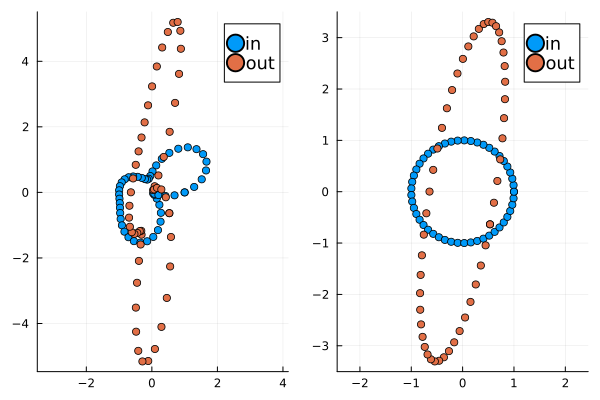

In [17]:
@show svdvals(A)
U, S, V = svd(A)
@show norm(U - U')
Aplot(A)

# Example: autonomous vehicles

* Need to solve least squares problems in real time
* Weight/cost/size increase with compute
* What algorithm to choose?
* What precision to use?

## Factors
* How many objects?
* Speed (of robot and objects)
* Aerial, wheeled, walking
* Fog, light -- longer memory?
* Tolerences (how accurate does the solution need to be?)
* Consequences of being wrong, who bears those consequences?

In [25]:
A = rand(5000, 500)
A_32 = Float32.(A)
@show cond(A)
@time qr(A);       # Householder; backward stable
@time qr_chol(A);  # Unstable
@time qr(A_32);

cond(A) = 56.21621342703861
  0.067741 seconds (7 allocations: 19.348 MiB)
  0.037107 seconds (8 allocations: 22.888 MiB)
  0.045914 seconds (7 allocations: 9.674 MiB)


In [27]:
V = vander(LinRange(-1, 1, 20))
@show cond(V)
Q, R = qr(Float32.(V))
@show norm(Q' * Q - I)
Q, R = qr_chol(V)
@show norm(Q' * Q - I)

cond(V) = 2.7224082312417406e8
norm(Q' * Q - I) = 1.6641898f-6
norm(Q' * Q - I) = 0.1749736012761826


0.1749736012761826

# Best low rank approximation

The SVD can be truncated to yield the best rank-$k$ approximation of a matrix.

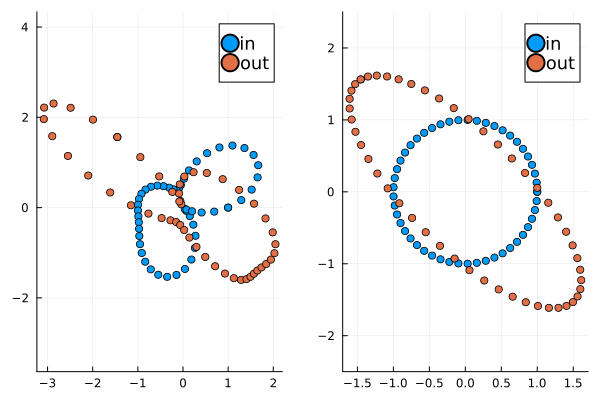

In [28]:
n, k = 2, 1
A = randn(n, n)
Aplot(A)

S[1:k + 1] = [2.142482775050614, 0.7866894479177035]
norm(Ahat) = 2.142482775050614


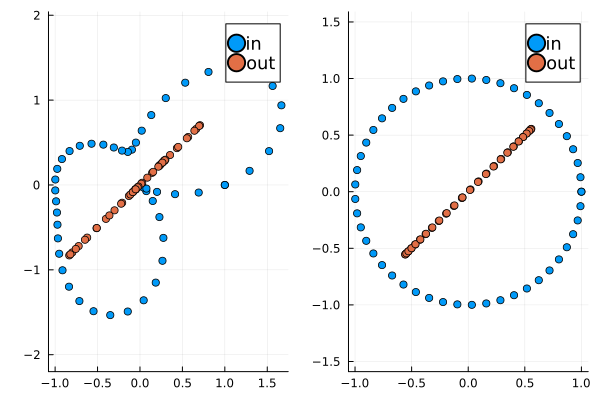

In [31]:
U, S, V = svd(A)
@show S[1:k+1]
Uhat = U[:, 1:k]
Shat = S[1:k]
Vhat = V[:, 1:k]
Ahat = Uhat * diagm(Shat) * Vhat'
@show norm(Ahat)
Aplot(Ahat - A)

# Example: Galaxies

Suppose we have two galaxies of size $n_1 = 100$ and $n_2 = 200$, each randomly distributed around their respective centers.

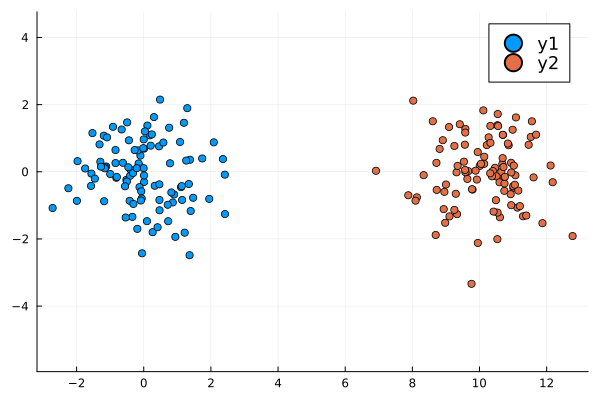

In [44]:
galaxy(center, sigma, n) = reshape(center, 1, 3) .+ sigma*randn(n, 3)
g1 = galaxy([0 0 0], 1, 100)
g2 = galaxy([10 0 0], 1, 100)

scatter(g1[:,1], g1[:,2], aspect_ratio=:equal)
scatter!(g2[:,1], g2[:,2])

## Forces between stars

Consider the gravitational force from a star at position $x_2$ acting on a star at position $x_1$,
$$ F_{1,2} = G \frac{m_1 m_2}{\lVert x_2 - x_1 \rVert^3} (x_2 - x_1) $$
where $m_1$ and $m_2$ are the masses of each star respectively.

In [45]:
function gravity(g1, g2)
    m = size(g1, 1)
    n = size(g2, 1)
    F = zeros(3*m, n)
    for i in 0:m-1
        for j in 1:n
            r = g2[j,:] - g1[1+i,:]
            F[1+3*i:3*(i+1),j] = r / norm(r)^3
        end
    end
    F
end
gravity(g1, g2)

300×100 Matrix{Float64}:
  0.00957861    0.0160052     0.00903842   …   0.0175968     0.00907843
  0.00041256    0.000760967  -0.000356393      0.00191593    0.0018601
 -0.000847752   0.00114359    0.000877223     -6.05134e-5   -0.00201754
  0.00749971    0.0115206     0.00693755       0.0127296     0.00749341
 -0.000154054  -0.000373843  -0.000637198      0.000201199   0.000895957
 -0.000353709   0.00114185    0.000802696  …   0.000472475  -0.0012234
  0.0111437     0.0199477     0.0103831        0.0226252     0.0109335
 -0.00104928   -0.00267252   -0.00186976      -0.00170139    0.000860172
 -0.00160558    0.000354605   0.000624766     -0.0015889    -0.0032019
  0.00710227    0.0119115     0.00731593       0.0124992     0.00676589
 -0.001024     -0.00226415   -0.00158559   …  -0.00181528    1.00586e-5
 -0.00234288   -0.00294483   -0.00109365      -0.00413747   -0.00312664
  0.00698416    0.0109464     0.00662522       0.0120304     0.00712998
  ⋮                                      

# Spectrum

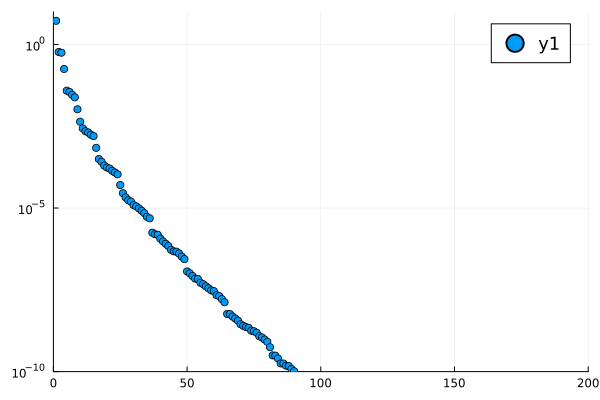

In [57]:
g1 = galaxy([0 0 0], 1, 500)
g2 = galaxy([10 0 0], 1, 500)
F = gravity(g1, g2)
U, S, V = svd(F)
scatter(S, yscale=:log10, ylims=(1e-10, 10), xlims=(0, 200))

In [11]:
k = 10
Uhat = U[:,1:k]
Shat = S[1:k]
Vhat = V[:,1:k]
Fhat = Uhat * diagm(Shat) * Vhat'
@show norm(F)
@show norm(F - Fhat)
size(F)

norm(F) = 74.35638936337672
norm(F - Fhat) = 31.382227066596844


(1500, 500)

# What is interpolation?

Given data $(x_i, y_i)$, find a (smooth?) function $f(x)$ such that $f(x_i) = y_i$.

## Data in

* direct field observations/measurement of a physical or social system
* numerically processed observations, perhaps by applying physical principles
* output from an expensive "exact" numerical computation
* output from an approximate numerical computation

## Function out

* Polynomials
* Piecewise polynomials (includes nearest-neighbor)
* Powers and exponentials
* Trigonometric functions (sine and cosine)
* Neural networks

Interpolation fits the data exactly!

# Polynomial interpolation

We've seen how we can fit a polynomial using Vandermonde matrices, one column per basis function and one row per observation.

$$ \underbrace{\Bigg[ 1 \Bigg| x \Bigg| x^2 \Bigg| x^3 \Bigg]}_{A \in \mathbb R^{m\times n}} \Bigg[ \mathbf p \Bigg] = \Bigg[ \mathbf y \Bigg] $$

It's possible to find a unique polynomial $\mathbf p$ when which of the following are true?
1. $m \le n$
2. $m = n$
3. $m \ge n$

# Polynomial interpolation with a Vandermonde matrix

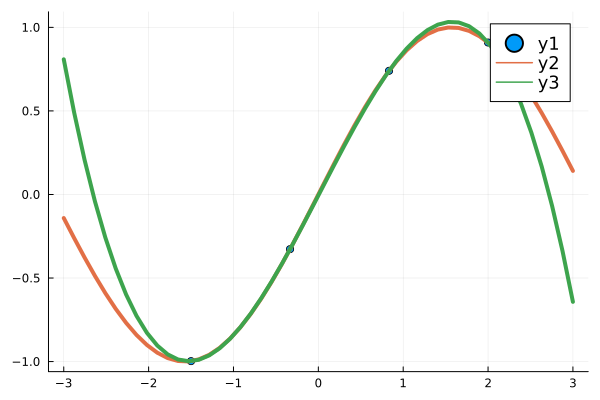

In [12]:
x = LinRange(-1.5, 2, 4)
y = sin.(x)
A = vander(x)
p = A \ y
 
scatter(x, y)
s = LinRange(-3, 3, 50)
plot!(s, [sin.(s) vander(s, length(p)) * p])

## Vandermonde matrices can be ill-conditioned

In [59]:
A = vander(LinRange(-1, 1, 20))
cond(A)

2.7224082312417406e8

1. It's because of the points $x$?
2. It's because of the basis functions $\{ 1, x, x^2, x^3, \dotsc \}$?